In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# sys.path.append('/Users/ef6/Documents/Saez/metalinks/PD_datas/Figures')
from aux import *
import matplotlib.gridspec as gridspec

In [52]:
DB = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks_analysis/metalinksDB/DB_F_0.4.5.csv')
DB['connection'] = DB['HMDB'] + '_' + DB['Symbol']
DB['HMDB'] = DB['HMDB'].str.replace('"', '')
DB['Symbol'] = DB['Symbol'].str.replace('"', '')
len(DB['connection'].unique())

10242

In [40]:
metalinks_data = load_prepro_metalinks(MR_path='/Users/ef6/Documents/GitHub/metalinks_analysis/metalinksDB/DB_F_0.4.5.csv')
# PD = metalinks_data[0]

# temporary fix
PD_data = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks_analysis/metalinksDB/PD_0.4.5.csv')
PD_data['HMDB'] = PD_data['HMDB'].str.replace('"', '')
PD_data['Symbol'] = PD_data['Symbol'].str.replace('"', '')
PD_data['Direction'] = PD_data['Direction'].str.replace('"', '')
PD = PD_data[['HMDB', 'Symbol', 'Direction']]

MR = metalinks_data[1]
anno = metalinks_data[2]
data = load_prepro_other_dbs(MR, PD)
PD_metabolites = data[0]
MR_metabolites = data[1]
MR_proteins = data[2]
MR_interactions = data[3]

AttributeError: Can only use .str accessor with string values!

In [ ]:
scconnect = pd.read_csv('/Users/ef6/Documents/GitHub/scConnect/scConnect/data/GTP_tables_clean/2020-5/ligands.csv')
scconnect.dropna(subset=['PubChem CID'], inplace=True)
# keep only rows where Type is either 'Metabolite' or 'Inorganic'
scconnect = scconnect[scconnect['Type'].isin(['Metabolite', 'Inorganic'])]
interactions = pd.read_csv('/Users/ef6/Documents/GitHub/scConnect/scConnect/data/GTP_tables_clean/2020-5/interactions.csv')
interactions = interactions[interactions['ligand'].isin(scconnect['Name'])]
# interactions(['ligand', 'target', 'ligand_pubchem_sid', 'target_uniprot'])
interactions = interactions[['ligand', 'target', 'target_uniprot']]
interactions = interactions.merge(scconnect[['Name', 'PubChem CID']], left_on='ligand', right_on='Name')
interactions.drop(columns=['Name'], inplace=True)
interactions.drop_duplicates(inplace=True)
interactions.dropna(subset= ['PubChem CID', 'target_uniprot'], inplace=True)
interactions = interactions.assign(uniprot=interactions['target_uniprot'].str.split('|')).explode('uniprot')

/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_47938/1303409221.py:5: DtypeWarning: Columns (6,8,9,10,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions = pd.read_csv('/Users/ef6/Documents/GitHub/scConnect/scConnect/data/GTP_tables_clean/2020-5/interactions.csv')


In [ ]:
hmdb = anno.copy()
hmdb.dropna(subset=['pubchem_id'], inplace=True)
hmdb_dict = dict(zip( hmdb['pubchem_id'].astype(int), hmdb['accession']))

In [ ]:
from pypath.utils import mapping
uniprot_df = mapping.translation_df('uniprot', 'genesymbol')
if 'RORA' not in uniprot_df['genesymbol'].values: #solves weird error that sometimes pypath gives the wrong column names
    uniprot_df = uniprot_df.rename(columns={'genesymbol': 'uniprot', 'uniprot': 'genesymbol'})

uniprot_dict = dict(zip(uniprot_df['uniprot'], uniprot_df['genesymbol']))

In [ ]:
interactions['hmdb'] = interactions['PubChem CID'].astype(int).map(hmdb_dict)
interactions.dropna(subset=['hmdb'], inplace=True)
interactions['genesymbol'] = interactions['target_uniprot'].map(uniprot_dict)
# replace the genesymbol value with the target_name if the genesymbol is NA
interactions['genesymbol'] = np.where(interactions['genesymbol'].isna(), interactions['target'], interactions['genesymbol'])
# remove rows wehre the genesymbol contains a ' ' or '-' in the string
interactions = interactions[~interactions['genesymbol'].str.contains(' ') & ~interactions['genesymbol'].str.contains('-')& ~interactions['genesymbol'].str.contains('\.')]
interactions.drop_duplicates(inplace=True)
interactions['connection'] = interactions['hmdb'] + '_' + interactions['genesymbol']


/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_47938/757305995.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions.drop_duplicates(inplace=True)
/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_47938/757305995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions['connection'] = interactions['hmdb'] + '_' + interactions['genesymbol']


In [ ]:
cellinker = pd.read_csv('/Users/ef6/Documents/Saez/metalinks/Data/Source/Celllinker/human-sMOL.txt', sep='\t')
cellinker = cellinker.dropna(subset=['ligand_pubchem_cid'])
cellinker['ligand_pubchem_cid'] = cellinker['ligand_pubchem_cid'].astype(int)
cellinker['hmdb'] = cellinker['ligand_pubchem_cid'].map(hmdb_dict)
cellinker.dropna(subset=['hmdb'], inplace=True)
cellinker.dropna(subset=['Receptor_symbol'], inplace=True)
cellinker['connection'] = cellinker['hmdb'] + '_' + cellinker['Receptor_symbol']
cellinker.drop_duplicates(inplace=True)

In [ ]:
def preprocess_data_for_barplot(data, database_names, index_names):
    df = pd.DataFrame({database_names[0]: data[0], 
                       database_names[1]: data[1],
                       database_names[2]: data[2],
                       database_names[3]: data[3],
                       database_names[4]: data[4],
                       database_names[5]: data[5]}, index=index_names)
    df = df.reset_index()
    df = pd.melt(df, id_vars=['index'], value_vars=database_names)
    df.columns = ['index', 'Database', 'Count']
    df = df.sort_values(by=['index'])
    df['Database'] = pd.Categorical(df['Database'], categories=database_names)
    df = df.sort_values(by=['Database'])
    df['index'] = pd.Categorical(df['index'], categories=index_names)
    df = df.sort_values(by=['index'])
    df['Count'] = df['Count'].astype(int)
    return df

In [ ]:
MR_metabolites.append(cellinker['hmdb'].unique())
MR_metabolites.append(interactions['hmdb'].unique())
MR_metabolites = [MR_metabolites[i] for i in [0,1,4,2,5,3]]


In [ ]:
def prepare_fractions(data, df):
    nc_df = df[df['accession'].isin(data[0])]
    cp_df = df[df['accession'].isin(data[1])]
    cl_df = df[df['accession'].isin(data[2])]
    me_df = df[df['accession'].isin(data[3])]
    sc_df = df[df['accession'].isin(data[4])]
    ml_df = df[df['accession'].isin(data[5])]

    classes = df.columns[6:10]
    res = []
    for met_class in classes:
        fractions = pd.DataFrame()
        fractions['MetalinksDB'] = ml_df[met_class].value_counts(normalize=True)
        fractions['scConnect'] = sc_df[met_class].value_counts(normalize=True)
        fractions['NeuronChat'] = nc_df[met_class].value_counts(normalize=True)
        fractions['CellphoneDB'] = cp_df[met_class].value_counts(normalize=True)
        fractions['Cellinker'] = cl_df[met_class].value_counts(normalize=True)
        fractions['MebocostDB'] = me_df[met_class].value_counts(normalize=True)
        s = fractions.sum(axis=1)
        fractions = fractions[s > 0.09]
        colsums = fractions.sum(axis=0)
        others = pd.DataFrame({'MetalinksDB': 1 - colsums['MetalinksDB'], 
                                'scConnect': 1 - colsums['scConnect'],
                               'NeuronChat': 1 - colsums['NeuronChat'],
                               'CellphoneDB': 1 - colsums['CellphoneDB'], 
                                'Cellinker': 1 - colsums['Cellinker'],                               
                               'MebocostDB': 1 - colsums['MebocostDB']
                               }, index=['Others'])
        fractions = pd.concat([fractions, others])
        fractions = fractions.fillna(0)
        res.append(fractions)

    return res

In [ ]:
def prepro_hm(hm):

    hm = hm.fillna(0).iloc[:, ::-1]
    hm = hm[['NeuronChat', 'CellphoneDB','Cellinker', 'MebocostDB', 'scConnect', 'MetalinksDB']]
    hm.columns = ['NeuronChat', 'CellphoneDB','Cellinker', 'MebocostDB', 'scConnect', 'MetalinksDB']
    # hm.index = ['Organoheterocyclic compounds', 'Benzenoids',
    #     'Lipids and lipid-like molecules', 'Organic acids and derivatives',
    #     'Organic oxygen compounds', 'Nucleosides, nucleotides',
    #     'Organic nitrogen compounds', 'Homogeneous non-metal compounds',
    #     'Others']
    return hm

In [ ]:
# BARPLOT
NeuronChat = [len(MR_interactions[0]), len(MR_metabolites[0]), len(MR_proteins[0])]
CellPhoneDB = [len(MR_interactions[1]), len(MR_metabolites[1]), len(MR_proteins[1])]
MebocostDB = [len(MR_interactions[2]), len(MR_metabolites[2]), len(MR_proteins[2])]
MetalinksDB = [len(MR_interactions[3]), len(MR_metabolites[3]), len(MR_proteins[3])]
scConnect = [len(interactions['connection'].unique()), len(interactions['hmdb'].unique()), len(interactions['genesymbol'].unique())]
CellLinker = [len(cellinker['connection'].unique()), len(cellinker['hmdb'].unique()), len(cellinker['Receptor_symbol'].unique())]

# write the above as function that takes a list of lists as input
df = preprocess_data_for_barplot([NeuronChat, CellPhoneDB,CellLinker, MebocostDB, scConnect, MetalinksDB], ['NeuronChat', 'CellphoneDB', 'Cellinker', 'MebocostDB','scConnect', 'MetalinksDB'], ['Interactions', 'Metabolites', 'Proteins'])
# HEATMAP

matrix = prepare_fractions(MR_metabolites, anno)

hm = prepro_hm(matrix[2])

In [ ]:
PD_metabolites.append(['HMDB0000068', 'HMDB0000216', 'HMDB0000073', 'HMDB0000895','HMDB0000259', 'HMDB0000148', 'HMDB0000112', 'HMDB0000123' ])
PD_metabolites = [PD_metabolites[i] for i in [0,1,2,4,3]]

In [41]:
df

,index,Database,Count
0,Interactions,NeuronChat,127
12,Interactions,scConnect,628
9,Interactions,MebocostDB,414
15,Interactions,MetalinksDB,10242
6,Interactions,Cellinker,254
3,Interactions,CellphoneDB,248
4,Metabolites,CellphoneDB,47
7,Metabolites,Cellinker,105
10,Metabolites,MebocostDB,105
1,Metabolites,NeuronChat,10


In [42]:
def get_jaccard(hmdb_ids):
    matrix_size = len(hmdb_ids)
    jaccard_matrix = np.zeros((matrix_size, matrix_size))

    for i in range(matrix_size):
        for j in range(i, matrix_size):
            set1 = set(hmdb_ids[i])
            set2 = set(hmdb_ids[j])
            intersection = len(set1.intersection(set2))
            union = len(set1.union(set2))
            jaccard_index = intersection / union
            jaccard_matrix[i, j] = jaccard_index
            jaccard_matrix[j, i] = jaccard_index

    # Print the Jaccard matrix
    return(jaccard_matrix)

/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_47938/1508237678.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=values, orient='h', ax=ax3, palette=colors_extended_short, saturation=0.75)


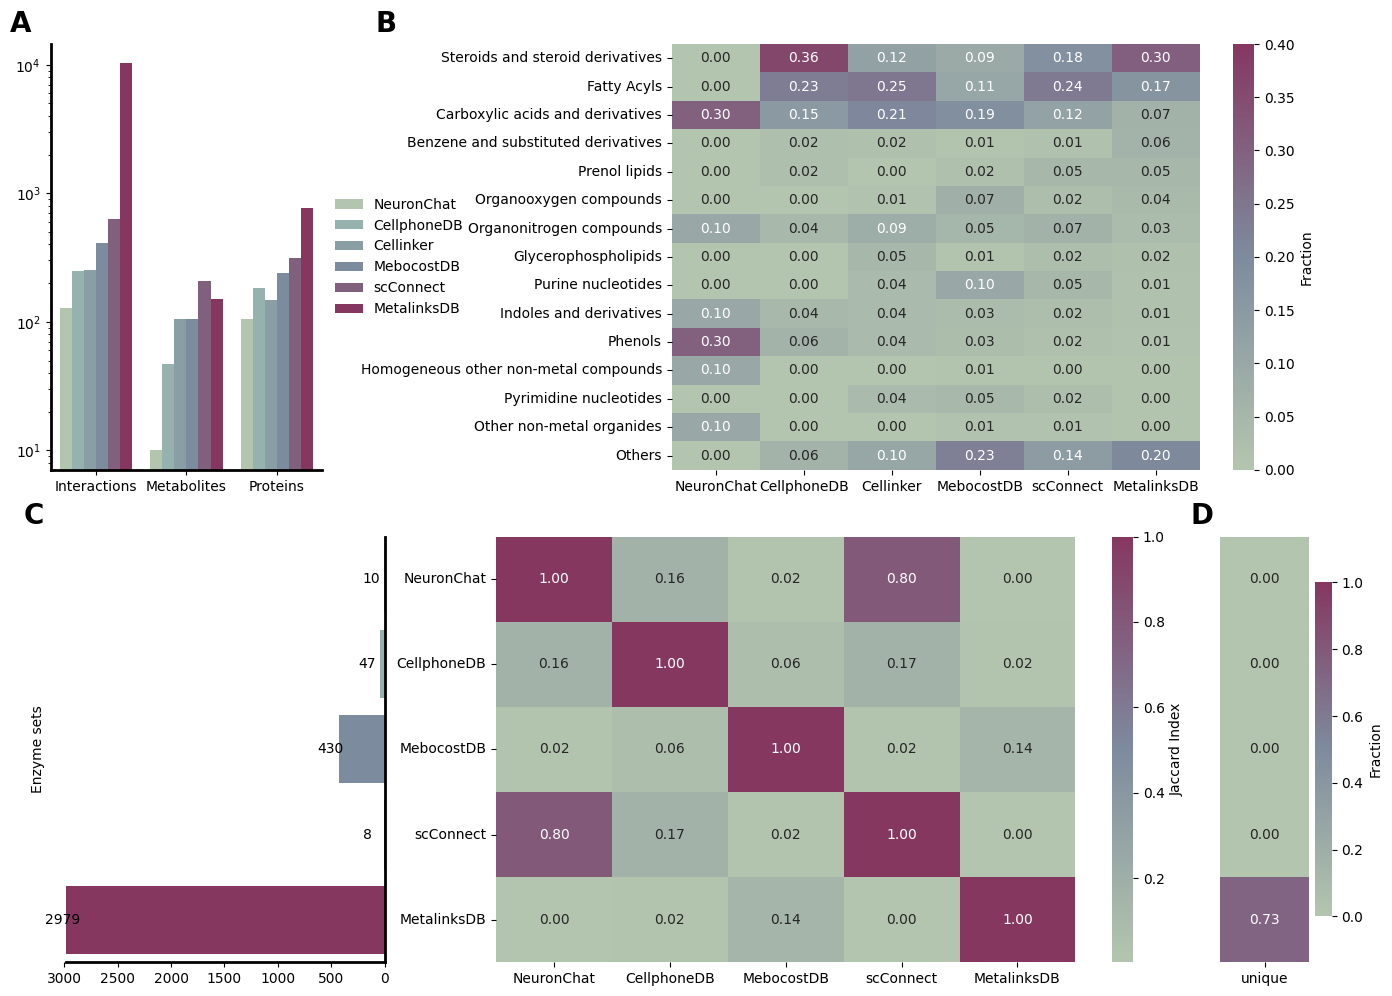

In [43]:
values = [len(x) for x in PD_metabolites]
matrix1 = get_jaccard(PD_metabolites)
matrix2 = count_shared_and_unique_metabolites(PD_metabolites)

def figure_2(df, hm, values, matrix1, matrix2, subject='Enzyme sets'):
    labels = ['NeuronChat', 'CellphoneDB', 'MebocostDB', 'scConnect', 'MetalinksDB']
    row_labels = ['NeuronChat', 'CellphoneDB', 'MebocostDB', 'scConnect', 'MetalinksDB']
    col_labels = ['NeuronChat', 'CellphoneDB', 'MebocostDB', 'scConnect', 'MetalinksDB']
    data1 = np.array(matrix1)
    data2 = np.array(matrix2)
    # remove first columns of data2
    data2 = data2[:, 1:]
    
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,2])
    gs_upper = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0, 0], wspace=0.0, width_ratios=[7, 9, 17])
    gs_lower = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1, 0], wspace=0.0, width_ratios=[6, 2, 13, 2])

    colors = ['#B2C9AB', '#92B6B1', '#788AA3', '#932A61']  
    colors_extended = ['#B2C9AB', '#92B6B1', '#85a0aa', '#788AA3','#865A82', '#932A61']
    colors_extended_short = ['#B2C9AB', '#92B6B1', '#788AA3','#865A82', '#932A61']
    color_list = ['#B2C9AB',  '#788AA3', '#932A61']# '#92B6B1'
    color_list_r = ['#932A61','#788AA3', '#92B6B1', '#B2C9AB']
    adjusted_colors = [sns.desaturate(c, 0.75) for c in color_list]
    cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', adjusted_colors)


    colormap = 'cividis'
    colormap = cmap_custom
    ax1 = plt.subplot(gs_upper[ 0])
    sns.barplot(data=df, x='index', y='Count', hue='Database', ax=ax1, palette=colors_extended)
    ax1.set_yscale('log')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # remove box around the legend
    ax1.get_legend().get_frame().set_linewidth(0.0)

    ax6 = plt.subplot(gs_upper[1])
    # make a white plain for ax6
    ax6.axis('off') 

    ax2 = plt.subplot(gs_upper[0, 2])
    sns.heatmap(hm, annot=True, cmap=colormap, fmt='.2f', vmin=0, vmax=0.4, ax=ax2 )
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    cbar = ax2.collections[0].colorbar
    cbar.set_label('Fraction')

    ax3 = plt.subplot(gs_lower[0])
    sns.barplot(y=labels, x=values, orient='h', ax=ax3, palette=colors_extended_short, saturation=0.75)
    ax3.grid(False)
    ax3.set_facecolor('white')
    for i, value in enumerate(values):
        ax3.text(value + 200, i, str(value), va='center', color='black')
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    ax3.spines['bottom'].set_bounds(0, max(values))
    ax3.invert_xaxis()
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax3.set_ylabel(subject)

    ax6 = plt.subplot(gs_lower[1])
    # make a white plain for ax6
    ax6.axis('off')

    ax4 = plt.subplot(gs_lower[2])
    sns.heatmap(data1, annot=True, cmap=colormap, fmt='.2f', xticklabels=col_labels, yticklabels=row_labels, ax=ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
    ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)
    cbar1 = ax4.collections[0].colorbar
    cbar1.set_label('Jaccard Index', size=10)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_linewidth(2)
    ax4.spines['bottom'].set_linewidth(2)

    ax5 = plt.subplot(gs_lower[3])
    sns.heatmap(data2, annot=True, cmap=colormap, fmt='.2f', xticklabels=[ 'unique'], yticklabels=row_labels, vmin=0, vmax=1, ax=ax5)
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0)
    ax5.set_yticklabels([])
    ax5.set_yticks([])
    cbar2 = ax5.collections[0].colorbar
    cbar2.set_label('Fraction', size=10)
    ax5.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.spines['left'].set_linewidth(2)    # hm.index = ['Organoheterocyclic compounds', 'Benzenoids',
    #     'Lipids and lipid-like molecules', 'Organic acids and derivatives',
    #     'Organic oxygen compounds', 'Nucleosides, nucleotides',
    #     'Organic nitrogen compounds', 'Homogeneous non-metal compounds',
    #     'Others']
    ax5.spines['bottom'].set_linewidth(2)

    ax1.text(-0.07, 1.08, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax2.text(-0.52, 1.08, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax3.text(-0.02, 1.08, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax4.text(-0.02, 1.08, '', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax5.text(-0.07, 1.08, 'D', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


    plt.tight_layout()
    plt.show()

figure_2(df, hm, values, matrix1, matrix2)


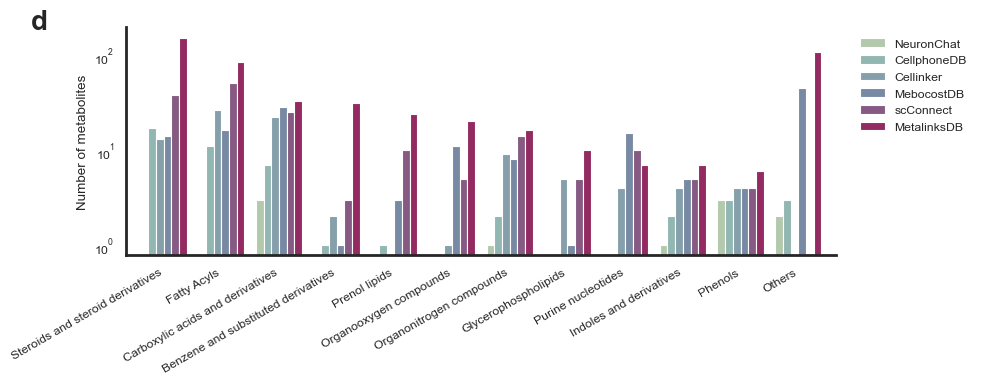

In [44]:
def prepare_absolute(data, df):
    nc_df = df[df['accession'].isin(data[0])]
    cp_df = df[df['accession'].isin(data[1])]
    cl_df = df[df['accession'].isin(data[2])]
    me_df = df[df['accession'].isin(data[3])]
    sc_df = df[df['accession'].isin(data[4])]
    ml_df = df[df['accession'].isin(data[5])]

    classes = df.columns[6:10]
    res = []
    for met_class in classes:
        fractions = pd.DataFrame()
        fractions['MetalinksDB'] = ml_df[met_class].value_counts()
        fractions['scConnect'] = sc_df[met_class].value_counts()
        fractions['NeuronChat'] = nc_df[met_class].value_counts()
        fractions['CellphoneDB'] = cp_df[met_class].value_counts()
        fractions['Cellinker'] = cl_df[met_class].value_counts()
        fractions['MebocostDB'] = me_df[met_class].value_counts()
        s = fractions.sum(axis=1)
        fractions = fractions[s > 20]
        colsums = fractions.sum(axis=0)
        others = pd.DataFrame({'MetalinksDB': len(ml_df.index) -colsums['MetalinksDB'], 'NeuronChat': len(nc_df.index) - colsums['NeuronChat'], 'CellphoneDB': len(cp_df.index) - colsums['CellphoneDB'], 'MebocostDB': len(me_df.index) - colsums['MebocostDB']}, index=['Others'])
        fractions = pd.concat([fractions, others])
        fractions = fractions.fillna(0)
        res.append(fractions)

    return res

matrix = prepare_absolute(MR_metabolites, anno)
hm = matrix[2]
hm = hm[['NeuronChat', 'CellphoneDB', 'Cellinker', 'MebocostDB','scConnect', 'MetalinksDB']]
hm.columns = ['NeuronChat', 'CellphoneDB', 'Cellinker', 'MebocostDB','scConnect', 'MetalinksDB']

# prepare grouped barplot from hm using seaborn
sns.set_style('white')
sns.set_context('paper')

fig, ax = plt.subplots(figsize=(10, 4))
# colors = ['#932A61', '#512D55']
colors = ['#B2C9AB', '#92B6B1', '#85a0aa', '#788AA3','#865A82', '#932A61']
sns.set_palette(colors)
hm.plot(kind='bar',  ax=ax, width=0.8)
ax.set_ylabel('Number of metabolites')
ax.set_xlabel('')
ax.set_yscale('log')
ax.set_xticklabels(hm.index, rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
# rotate labels on x axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), frameon=False)
ax.text(-0.11, 1.08, 'd', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.show()


In [70]:
table_s2 = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks_analysis/Data/SuppTable02.csv')
table_s2['connection'] = table_s2['HMDB'] + '_' + table_s2['Symbol']
table_s2.sort_values(by='metalinks', key=lambda x: abs(x), ascending=False, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ef6/Documents/GitHub/metalinks_analysis/Data/SuppTable02.csv'

In [26]:
MR_interactions.append(cellinker['connection'].unique())
MR_interactions.append(interactions['connection'].unique())

In [27]:

# from matplotlib_venn import venn3
# from matplotlib_venn import venn2
# from matplotlib_venn import venn2_circles
# from matplotlib_venn import venn3_circles

# fig, ax = plt.subplots(figsize=(10, 10))
# venn3([set(MR_cut[0]), set(MR_cut[1]), set(MR_cut[2])], set_labels=['NeuronChat', 'CellphoneDB', 'Cellinker'])
# plt.show()

# # do a similar plot with all the 6 elements of MR_cut
# fig, ax = plt.subplots(figsize=(10, 10))
# venn3([set(MR_cut[0]), set(MR_cut[1]), set(MR_cut[2])], set_labels=['NeuronChat', 'CellphoneDB', 'Cellinker'])
# plt.show()

# make bar chart with length of each list in MR_cut

# BARPLOT
NeuronChat = [len(MR_cut[0])]
NeuronChat_all = [len(MR_cut_all[0])]
CellPhoneDB = [len(MR_cut[1])]
CellPhoneDB_all = [len(MR_cut_all[1])]
MebocostDB = [len(MR_cut[2])]
MebocostDB_all = [len(MR_cut_all[2])]
MetalinksDB = [len(MR_cut[3])]
MetalinksDB_all = [len(MR_cut_all[3])]
scConnect = [len(MR_cut[4])]
scConnect_all = [len(MR_cut_all[4])]
CellLinker = [len(MR_cut[5])]
CellLinker_all = [len(MR_cut_all[5])]
df = preprocess_data_for_barplot([NeuronChat, CellPhoneDB,CellLinker, MebocostDB, scConnect, MetalinksDB], ['NeuronChat', 'CellphoneDB', 'Cellinker', 'MebocostDB','scConnect', 'MetalinksDB'], ['Databases'])
# df_all = preprocess_data_for_barplot([NeuronChat, CellPhoneDB,CellLinker, MebocostDB, scConnect, MetalinksDB], ['NeuronChat', 'CellphoneDB', 'Cellinker', 'MebocostDB','scConnect', 'MetalinksDB'], ['Databases'])
# sns.set_style('white')
# sns.set_context('paper')
# fig, ax = plt.subplots(figsize=(10, 4))
# colors = ['#B2C9AB', '#92B6B1', '#85a0aa', '#788AA3','#865A82', '#932A61']
# sns.set_palette(colors)
# sns.barplot(data=df, x='index', y='Count', hue='Database', ax=ax)
# ax.set_ylabel('Number of interactions')
# ax.set_xlabel('')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)
# # rotate labels on x axis
# ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), frameon=False)
# plt.tight_layout()
# plt.show()




NameError: name 'MR_cut' is not defined

/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_90674/2550950289.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Database', y='Count', ax=axs[0], palette=colors)
/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_90674/2550950289.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_90674/2550950289.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set

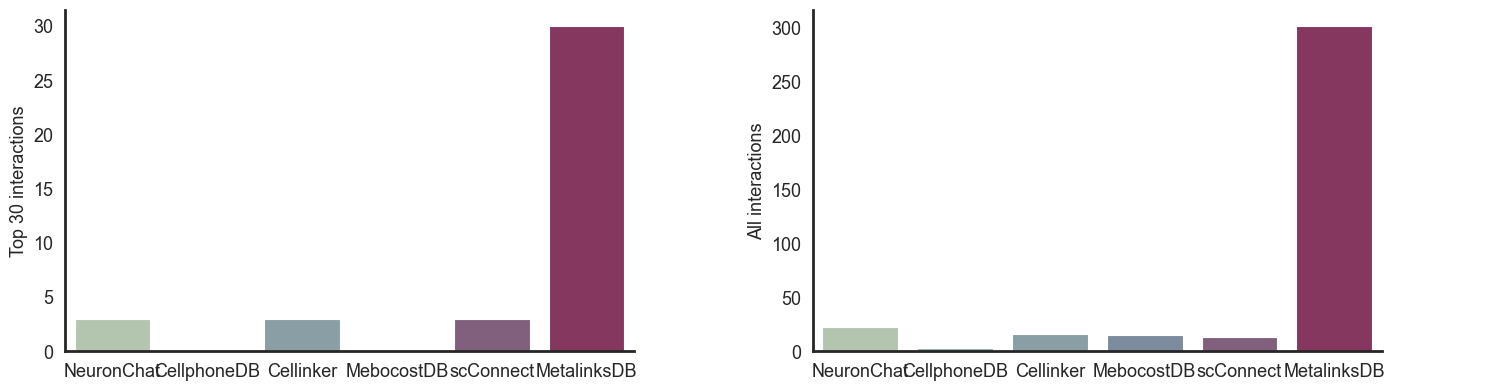

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

top30 = table_s2['connection'].head(30)
top_all = table_s2['connection']
MR_cut = MR_interactions.copy()
MR_cut_all = MR_interactions.copy()
# remove all elements from MR_cut that are not in top30
for i in range(len(MR_cut)):
    MR_cut[i] = [x for x in MR_cut[i] if x in top30.values]
    MR_cut_all[i] = [x for x in MR_cut_all[i] if x in top_all.values]

# Your data
NeuronChat = [len(MR_cut[0])]
NeuronChat_all = [len(MR_cut_all[0])]
CellPhoneDB = [len(MR_cut[1])]
CellPhoneDB_all = [len(MR_cut_all[1])]
MebocostDB = [len(MR_cut[2])]
MebocostDB_all = [len(MR_cut_all[2])]
MetalinksDB = [len(MR_cut[3])]
MetalinksDB_all = [len(MR_cut_all[3])]
scConnect = [len(MR_cut[4])]
scConnect_all = [len(MR_cut_all[4])]
CellLinker = [len(MR_cut[5])]
CellLinker_all = [len(MR_cut_all[5])]

# Preprocess data for barplot
df = pd.DataFrame({'Count': [NeuronChat[0], CellPhoneDB[0], CellLinker[0], MebocostDB[0], scConnect[0], MetalinksDB[0]],
                   'Database': ['NeuronChat', 'CellphoneDB', 'Cellinker', 'MebocostDB', 'scConnect', 'MetalinksDB'],
                   'Category': ['Databases'] * 6})

df_all = pd.DataFrame({'Count': [NeuronChat_all[0], CellPhoneDB_all[0], CellLinker_all[0], MebocostDB_all[0], scConnect_all[0], MetalinksDB_all[0]],
                       'Database': ['NeuronChat', 'CellphoneDB', 'Cellinker', 'MebocostDB', 'scConnect', 'MetalinksDB'],
                       'Category': ['Databases'] * 6})

sns.set_style('white')
sns.set_context('paper')


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

colors = ['#B2C9AB', '#92B6B1', '#85a0aa', '#788AA3','#865A82', '#932A61']
sns.set_palette(colors)

# Plot the first barplot on the left axis
sns.barplot(data=df, x='Database', y='Count', ax=axs[0], palette=colors)
axs[0].set_ylabel('Top 30 interactions', size=13)
axs[0].set_xlabel('')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), frameon=False)
# set font size to 12
axs[0].tick_params(labelsize=13)



# Plot the second barplot on the right axis
sns.barplot(data=df_all, x='Database', y='Count', ax=axs[1], palette=colors)
axs[1].set_ylabel('All interactions', size=13)
axs[1].set_xlabel('')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), frameon=False)
# set font size to 12
axs[1].tick_params(labelsize=13)
# y title as well



# Adjust layout
plt.tight_layout()
plt.show()


In [109]:

test1 = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks/biocypher-out/20240331215035/ReconProductionDegradation-part000.csv', sep='\t', header=None)
test2 = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks/biocypher-out/20240331215035/RheaProductionDegradation-part000.csv', sep='\t', header=None)
test3 = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks/biocypher-out/20240331215035/HmrProductionDegradation-part000.csv', sep='\t', header=None)
test4 = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks/biocypher-out/20240331215035/HmdbProductionDegradation-part000.csv', sep='\t', header=None)

In [110]:
# reduce test 1 column 0, 8, 9
test1 = test1[[0,3, 8, 9]]
test2 = test2[[0,3, 4, 5]]
test3 = test3[[0,3, 8, 9]]
test4 = test4[[0,2, 6, 7]]
test1.columns = ['HMDB', 'Direction', 'Uniprot', 'DB']
test2.columns = ['HMDB', 'Direction', 'Uniprot', 'DB']
test3.columns = ['HMDB', 'Direction', 'Uniprot', 'DB']
test4.columns = ['HMDB', 'Direction', 'Uniprot', 'DB']

In [111]:
test = pd.concat([test1, test2, test3, test4])
test.drop_duplicates(['HMDB', 'Direction', 'Uniprot'], inplace=True)


In [112]:
Uniprot = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks/biocypher-out/20240331232920/Protein-part000.csv', sep='\t', header=None)
Metabolite = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks/biocypher-out/20240331232920/SmallMolecule-part000.csv', sep='\t', header=None)

/var/folders/nv/yqjsg18n1tz0n9cys1xtqclm0000gq/T/ipykernel_7251/1452588791.py:2: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  Metabolite = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks/biocypher-out/20240331232920/SmallMolecule-part000.csv', sep='\t', header=None)


In [113]:
test = test[test['HMDB'].isin(Metabolite[0])]
test = test[test['Uniprot'].isin(Uniprot[0])]

In [114]:
test['HMDB'].nunique()

2979

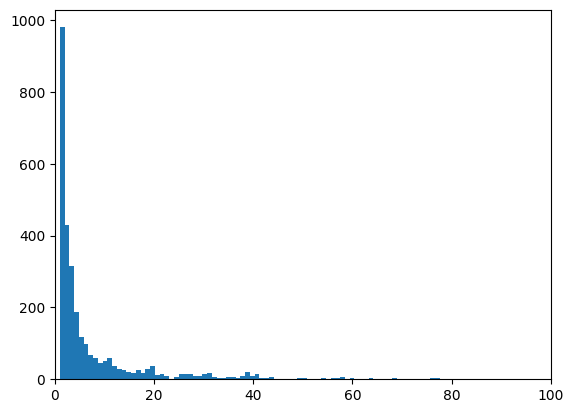

In [115]:
plt.hist(test['HMDB'].value_counts(), bins=3000)  
# set xlim
plt.xlim(0, 100)
# log x scale
# plt.yscale('log')
plt.show()

In [123]:
PD = pd.read_csv('/Users/ef6/Documents/GitHub/metalinks_analysis/metalinksDB/PD_test2.csv')
PD['HMDB'] = PD['HMDB'].str.replace('"', '')
PD.HMDB.nunique()

2979

In [121]:
test['DB'].value_counts()

DB
ReconProductionDegradation    20244
HmdbProductionDegradation      6572
RheaProductionDegradation      5368
HmrProductionDegradation       4281
Name: count, dtype: int64

In [122]:
test['fuse'] = test['HMDB'] + '_' + test['DB']
test['fuse'].

4168